<h1>Which tweet has been published from which news agency?<h1> 


My research subject is to see how well a prediction model works when I select tweeter accounts in a similar concepts and train the data data sets of tweets. I came up with a idea of sports news data sets were gathered from Tweeter API.    
5 sports news agency accounts are selected.These are "cbcsports", "BBCSport", "SkySportsNews", "beINSPORTS_EN", and "Sport24news"     
1500 tweets per account from 1 Decembe 2020 until today.  
My prediction model is done with Naive Bayes MultinomialNB



Gamze Bozkurt

Fundamentals of Machine Learning

University of Applied Sciences Utrecht

In [19]:
import tweepy
from datetime import datetime
import json
import requests
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


consumer_key = "m20frh2KA7id8wYdPGLdwfdUt"
consumer_secret = "f0rviwv8UPmwdjMPEoSHAkbulPY9VvC0fKxjquv7OKZ1D3XXXI"

access_token = "217025602-w80ni21i7EaEcTICqSpWxmXr3jqWkNJJigrIQDxe"
access_token_secret = "Y6NVAJ6vDT4P931mDtKHY9Oo2Ghb0dZgbBqN7fusm8m0w"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

<h1>DEFINITIONS<h1>

<ul><li>With the cleandate function, all the tweet texts are planned to have the same  date format and it is necessary to get rid of the twitter's default format</li>
<li>With textclean function, all the tweets' full text ( which is my base variable in this project) were cleaned by good tricks.I realized that full text has the information that exists in the other attribute of json file</li> </ul>

In [20]:
def cleanDate(date, source = "twitter"):
    #newDate = datetime(1970,1,1)
   # date format -> DDD MMM dd zzzz ZZZ YYYY
    seperatedDate = date.split()
    seperatedDate = seperatedDate[2] + " " + seperatedDate[1] + " " + seperatedDate[5]
    newDate = datetime.strptime(seperatedDate,"%d %b %Y")
    hour = int(date.split()[3].split(":")[0])
    return newDate, hour

def textcln(tweet):
    #find and clean the urls and hashtags and the cleaning part is almost done. This part is tricky way to clean the data
    clean_text = tweet["full_text"]
    for url in tweet["entities"]["urls"]:
        if(url["url"] in clean_text):
            clean_text = clean_text.replace(url["url"],"")
    for url in tweet["user"]["entities"]["url"]["urls"]:
        if(url["url"] in clean_text):
            clean_text = clean_text.replace(url["url"],"")
    if("media" in tweet["entities"].keys()):
        for media in tweet["entities"]["media"]:
            if(media["url"] in clean_text):
                clean_text = clean_text.replace(media["url"],"")
    for hashtag in tweet["entities"]["hashtags"]:
        if(hashtag["text"] in clean_text):
            clean_text = clean_text.replace("#"+hashtag["text"],"")
    #remove newline characters
    while "\n" in clean_text:
        clean_text = clean_text.replace("\n","")
    #https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    #https://en.wiktionary.org/wiki/▶ getting formation about the unicode of icon then remove that scale for extensive cleaning
    
    #however, I still see emoji and symbols in my csv file, therefore additional 
    #cleaning is done using regular expressions (EXTENSIVE CLEANING)
    emoji_pattern = re.compile("["
        u"\U00000080-\U000FFFFF"  # emoticons
        u"\U00000021-\U0000002F"  # punctuation
        u"\U0000003A-\U00000040"  # punctuation2
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U000025B0-\U000025BF"  # Pointing Arrow
        u"\U0000007B-\U0000007E"  # Pointing Arrow
                           "]+", flags=re.UNICODE)
    
    # no emoji and no blank by strip()
    clean_text= emoji_pattern.sub(r' ', clean_text).strip()
    #one of the agency is using the word "more" at the end the tweet regularly 
    #In order not to bias the model, I decicded to remove more"
    if clean_text.endswith(" More"):
        clean_text= clean_text.replace(" More", "")
    return clean_text


In [3]:
# I put a timeframe limit because I wanted to have a certain time period. 
#Beginning of the december is suitable for the data set
date = datetime(2020, 12, 1) 

#I selected the famous global sports news agencies on tweeter
publisherList = ["cbcsports","BBCSport", "SkySportsNews", "beINSPORTS_EN", "Sport24news"]

#creating a dictionary that involves 24 length numpy array with zeros
hourDict = {"cbcsports":np.zeros((24)),
           "BBCSport":np.zeros((24)),
            "SkySportsNews":np.zeros((24)), 
            "beINSPORTS_EN":np.zeros((24)), 
            "Sport24news":np.zeros((24))
           }


#for each publisher in the publisher list,
for publisher in publisherList:
        #setting the counter zero in order to increase it for each tweet
        counter = 0
        
        #creating a jsonfile with the name of the agency
        with open(publisher+".json", "w") as outfile:
            
            #to have a new line
            outfile.write("[\n") 
            #to retrieve tweets page by page
            page = 0
            exit = False
            #get maximum 1500 tweets until 01.12.2020 as I set
            while(counter<1500):
                #retrieving the tweets (20 per page)                                    
                tweets = api.user_timeline(screen_name = publisher, tweet_mode='extended',count = 20,page=page) ##NOTE FOR NOT TAKING RETWEETS
                for tweet in tweets:
                    #if a tweet is retweet, continue. I do not want to take retweets in my data set
                    if(tweet._json["full_text"].startswith("RT ")):
                        continue
                    json.dump(tweet._json, outfile, indent=2)
                    outfile.write(",\n")
                    #take formatted date and the hour that tweet was created by cleandate function
                    tweetDate, hour = cleanDate(tweet._json["created_at"])
                    hourDict[publisher][hour] += 1 #increasing the number of tweet in that particular time
                    counter += 1
                    #if the date I set, is reached stop retrieving the tweets. This is like a stop sign
                    if tweetDate == date :
                        exit = True
                        break
                #it is written for exiting from while true loop
                if exit: 
                    break
                page += 1
            outfile.write("{}\n]")       


In [4]:
# open an empty dataframe with columns title
fulltext = pd.DataFrame([],columns = ["text","news agency", "retweet", "fav"]) 

for publisher in publisherList:
    with open(publisher+".json", "r") as infile:
        tweetlist = json.loads(infile.read())
        for tweet in tweetlist:
            if(tweet != {}):
                text = textcln(tweet)
                if text == "":
                    #with continue keyword, it goes to start of the closest loop. 
                    continue 
                newdct = {"text":[text],"news agency":[publisher], 
                          "retweet":[tweet ["retweet_count"]], 
                          "fav": [tweet["favorite_count"]] }
                #to get the fully text not to get all of the texts
                newdf = pd.DataFrame.from_dict(newdct)
                # increasing the index number
                fulltext = fulltext.append(newdf,ignore_index = True)
                
#to open a csv file name as textpub because I need to save the data for analysis
fulltext.to_csv("textpub.csv", index=False) 
        
        

In [13]:
df = pd.read_csv('textpub.csv')
#Taking the text from the df. We need to convert it to Unicode
text = df['text'].values.astype('U')
#Create the CV object, with English stop words
vect = CountVectorizer(stop_words='english') 
#I fit the model with the words from the review text
vect = vect.fit(text) 
# make a matrix
docu_feat = vect.transform(text) 

<ul>Since the data set consists heavily texts, Naive Bayes is the the best approach to train and test the model ( Simpsons exercise inspiration) </li> </ul>
<li>Calculates a probability that a text belongs to a certain category
<li>The frequency of each word determines the probability
<li>Works well with text classification 
<li>Treats each unique word as a feature
<li>The independent features assumption of Naive Bayes make it a strong performer for classifying texts </li> </ul>


In [14]:
from sklearn.naive_bayes import MultinomialNB 

#create the model
nb = MultinomialNB() 
#the document-feature matrix is the X matrix
X = docu_feat 
#creating the y vector
y = df['news agency'] 

#split the data and store it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

#fit the model 
nb = nb.fit(X_train, y_train) 

In [15]:
#Evaluate the model
y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.7620558375634517

currently, accuracy of my model is 76 percent but if I want to increase its accuracy, I can add other variables to the dataframe. I have retweets counts and favourite counts. They will be effective on my model.

<h1>PRE-PROCESSING<h1>


Retweets counts and favourite counts are added

In [16]:
df = pd.read_csv('textpub.csv')
#Taking the text from the df. We need to convert it to Unicode
text = df['text'].values.astype('U')
#Create the CV object, with English stop words
vect = CountVectorizer(stop_words='english') 
#I fit the model with the words from the review text
vect = vect.fit(text) 
# make a matrix
docu_feat = vect.transform(text) 

#add the retweet and favourite counts to the matrix
#https://stackoverflow.com/questions/42931920/pandas-countvectorizer-how-to-filter-rows-quickly
docu_feat = np.insert(docu_feat.toarray(),len(docu_feat.toarray()[0]),np.int32(df["fav"].to_numpy()),axis=1)
docu_feat = np.insert(docu_feat,len(docu_feat[0]),np.int32(df["retweet"].to_numpy()),axis=1)

In [17]:
from sklearn.naive_bayes import MultinomialNB 

#create the model
nb = MultinomialNB() 
#the document-feature matrix is the X matrix
X = docu_feat 
#creating the y vector
y = df['news agency'] 

#split the data and store it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

#fit the model 
nb = nb.fit(X_train, y_train) 

<h1>MODEL RESULT<h1>

## The accuracy is about %82 which is awesome! The reasons are; 
<ul>
    <li>having good amount of extensive cleaning</li>
    <li>choosing right agencies as they have a different news under sport concept</li>
    <li>adding favourites and retweet counts make my model more accurate because the data set become more predictable with the additional feature</li>
    
</ul>

In [7]:
#Evaluate the model
y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.8261421319796954

<h1>CONFUSION MATRIX<h1>

To describe the performance of a classification model on the test data, I created a confusion matrix. It indicates that this model's test data mostly confused when predicting cbcsports. 109 of the tweets by cbcsports were predicted as BBCSport. 

In [23]:
cm = confusion_matrix(y_test, y_test_p)
#[s+ "_pred" for s in publisherList. it is iteration]
cm = pd.DataFrame(cm, index= publisherList, columns=[publisher+ "_pred" for publisher in publisherList]) 
cm

,cbcsports_pred,BBCSport_pred,SkySportsNews_pred,beINSPORTS_EN_pred,Sport24news_pred
cbcsports,136,63,86,91,62
BBCSport,66,39,52,48,42
SkySportsNews,107,49,79,67,45
beINSPORTS_EN,74,42,64,51,42
Sport24news,73,43,63,49,43


To see precision and recall table from the outcome. This is not the entire data set. 
when the recall is low, it means that individual accuracy is low. 
when the precision is low, it means that the probability of false prediction is high of that agency. SkySportsNews has the lowest precision and second highest recall. In this case, SkySportsNews has the lowest precision. According to the table, it means that my model tends to predict SkySportsNews when it predicts falsely cbcsports.

cbcsports has the lowest recall so in this agency that shows my model tends to predict false negatives. 


Precision: Precision   is   used   to   measure   the   positive patterns  that  are  correctly  predicted  from  the total predicted patterns in a positive class.  

Recall: It is   used   to   measure   the   fraction   of positive patterns that are correctly classified 


A Review on Evaluation Metrics for Data Classification Evaluations. Available from: https://www.researchgate.net/publication/275224157_A_Review_on_Evaluation_Metrics_for_Data_Classification_Evaluations [accessed Jan 20 2021].


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_p))

               precision    recall  f1-score   support

     BBCSport       0.84      0.76      0.80       470
SkySportsNews       0.63      0.91      0.74       219
  Sport24news       0.87      0.95      0.91       370
beINSPORTS_EN       0.91      0.85      0.88       275
    cbcsports       0.91      0.67      0.77       242

     accuracy                           0.83      1576
    macro avg       0.83      0.83      0.82      1576
 weighted avg       0.84      0.83      0.83      1576



To have a visual look with the tweet's hour, a snsbarplot is created for each agency. It is seen that every agency except sports24news has tweets in the evening in a very intense flow

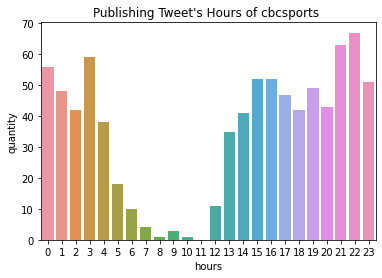

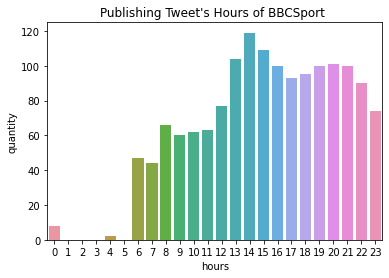

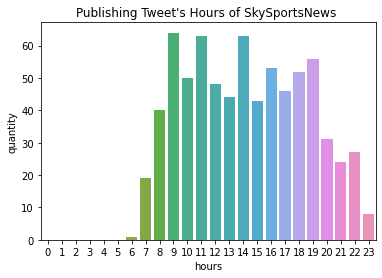

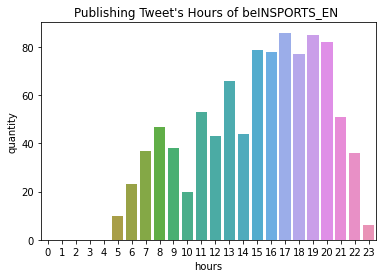

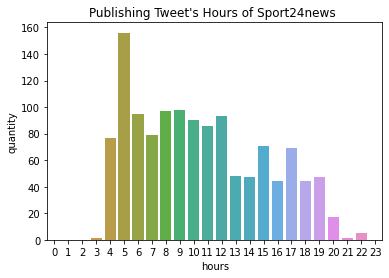

In [10]:
dfhour= pd.DataFrame(hourDict)

for key in hourDict.keys():
    ax=sns.barplot(x=list(range(24)) ,y = key,data = dfhour )
    ax.set(xlabel='hours', ylabel='quantity')
    plt.title("Publishing Tweet's Hours of {} ".format(key)) 
    plt.show()

<h1>VISUALIZATION OF FREQUENTLY USED WORDS<h1>

<ul>Thanks for visualising ideas from an article that helps to give idea how to show the most used words ( two words

https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a <ul> 



In [11]:
def get_top_n_bigram(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


As it is seen in the graphs, covid 19 is in the frequently used words in every news agency

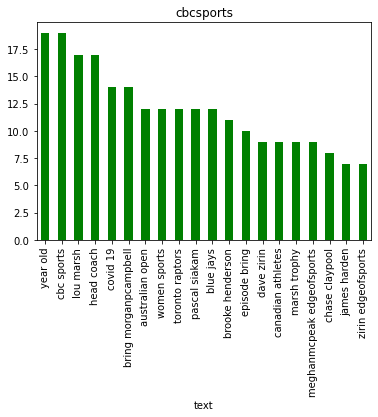

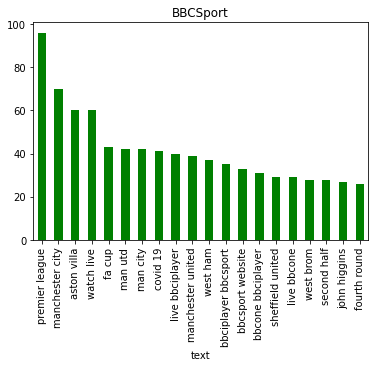

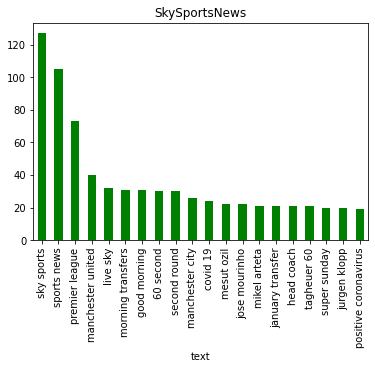

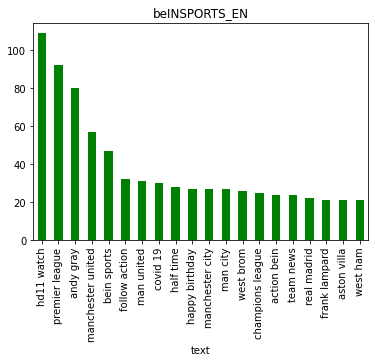

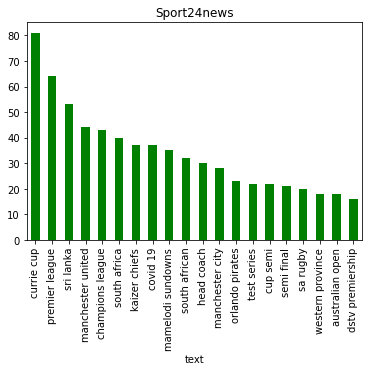

In [12]:
for publisher in publisherList:
    df3 = df.iloc[list(df.where(df["news agency"] == publisher).dropna().index)]
    common_words = get_top_n_bigram(df3["text"], 20)
    
    df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
    df4.groupby('text').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', y='Count', colormap= "ocean" , title='Top 20 bigrams in review after removing stop words')
    plt.title(publisher)
    plt.show()

<h1>REFERENCES<h1>

<ul>1-Kulagin , D. Pandas + CountVectorizer: how to filter rows quickly. Stack Overflow. https://stackoverflow.com/questions/42931920/pandas-countvectorizer-how-to-filter-rows-quickly. 
     
2-Li, S. (2019, April 27). A Complete Exploratory Data Analysis and Visualization for Text Data. Medium. https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a.  
     
3-Mohammad, H., &amp; M.n, S. (2015). A Review on Evaluation Metrics for Data Classification Evaluations. International Journal of Data Mining &amp; Knowledge Management Process, 5(2), 01–11. https://doi.org/10.5121/ijdkp.2015.5201   
    
4-Mona Jalal, M. removing emojis from a string in Python. Stack Overflow.   
https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python.  
     
5-Wiktionary:Main Page. Wiktionary, the free dictionary. https://en.wiktionary.org/wiki. 
    
 <ul> 